In [1]:
# from subjects.subjectsfunctions import *
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import dill as pickle
from analysis.plotfunctions import plotNovelExampleGenLCs, removeSpines, plotExampleGenMetrics, make_autopct, plotContextGenIdealizedConfMats, \
    plotContextGenSubjectConfMats, plotBayesianWithAssessment
from analysis.general import smooth, bayesianOneSampleTTest, figurePrototypesConversion
from subjects.subjectsfunctions import splitSubjectsCatGenPerf, calcSubjectsGenAxis, subjectsCatGenFirstChoice, \
    calcSubjectsNovelExampleGenTaskFirstCorrectGen, calcExampleGenMetricStats, calcLCInitialErrorConfMat, createSetGenBarDfHelper, \
    calcContextGenStats
from analysis.fitting import fitBayesianWithAssessment

# Functions 

# Load data
The data is available separately in the repository X. Please place it in the subject/data directory for everything to move smoothly

In [2]:
file_dir = 'subjects/data/'

data_CGv1 = pd.read_csv(os.path.join(file_dir, 'context_generalization_v1_behavior.csv'))
subjects_CGv1 = pd.read_csv(os.path.join(file_dir, 'context_generalization_v1_subjects.csv'))
data_CGv2_initial = pd.read_csv(os.path.join(file_dir, 'context_generalization_v2_behavior_initial.csv'))
data_CGv2_replication = pd.read_csv(os.path.join(file_dir, 'context_generalization_v2_behavior_replication.csv'))
subjects_CGv2_initial = pd.read_csv(os.path.join(file_dir, 'context_generalization_v2_subjects_initial.csv'))
subjects_CGv2_replication = pd.read_csv(os.path.join(file_dir, 'context_generalization_v2_subjects_replication.csv'))
data_EG_initial = pd.read_csv(os.path.join(file_dir, 'example_generalization_behavior_initial.csv'))
data_EG_replication = pd.read_csv(os.path.join(file_dir, 'example_generalization_behavior_replication.csv'))
subjects_EG_initial = pd.read_csv(os.path.join(file_dir, 'example_generalization_subjects_initial.csv'))
subjects_EG_replication = pd.read_csv(os.path.join(file_dir, 'example_generalization_subjects_replication.csv'))


# Example Generalization
## Plot the learning curves
You can change the dataset from the initial (data_EG_initial) to the replication (data_EG_replication)

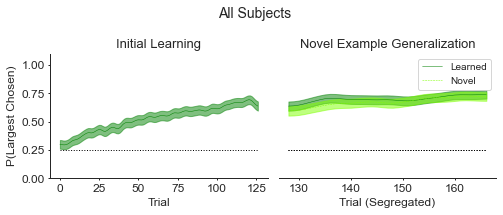

In [3]:
data = data_EG_initial # data_EG_initial, data_EG_replication

performance_categorization_mat, performance_learned_mat, performance_novel_mat, \
    subj_ids = splitSubjectsCatGenPerf(data, 
        generalization_att='texture',
        perf_thresh=0.0,
        n_trials_back=10,
        return_subject_ids=True)

fig_dir = 'plots/subjects/'
perf_thresh = 0.5
n_trials_back = 10
extension = 'svg'

sns.set_style(style='white')

plotNovelExampleGenLCs(performance_categorization_mat,performance_learned_mat,performance_novel_mat,
                       ttl=f'All Subjects',fontsize=12)
# plt.savefig(os.path.join(fig_dir,f'neg_lc_all.{extension}'),dpi=300)

plt.show()

## Plot the summary data

(<Figure size 1200x400 with 3 Axes>,
 array([<AxesSubplot:title={'center':'First Generalization Appearance'}, xlabel='P(Correct | Novel, First Gen Appearance) -\nP(Correct | Learned, First Gen Appearance)', ylabel='Probability'>,
        <AxesSubplot:title={'center':'Paired Generalization Difference'}, xlabel='P(Error | Novel) - P(Error | Learned)', ylabel='Probability'>,
        <AxesSubplot:title={'center':'Exploration Errors'}, xlabel='P(Choose D | Novel Stim)', ylabel='Probability'>],
       dtype=object))

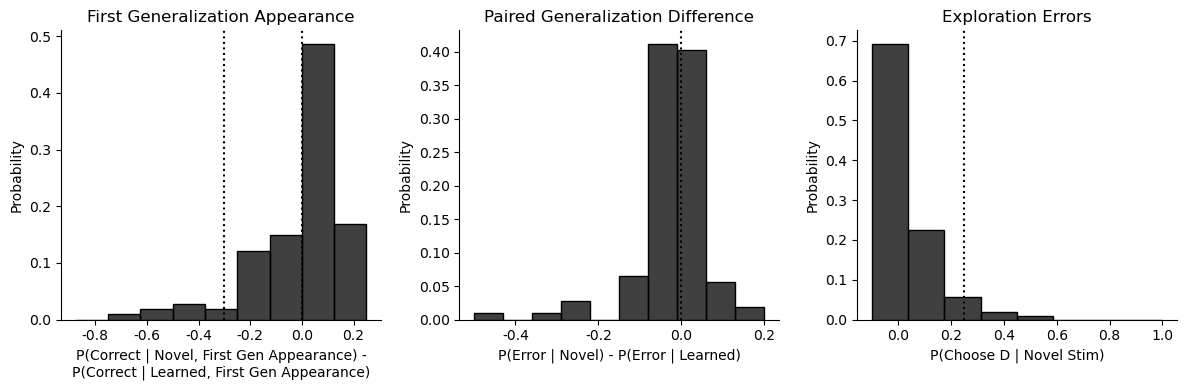

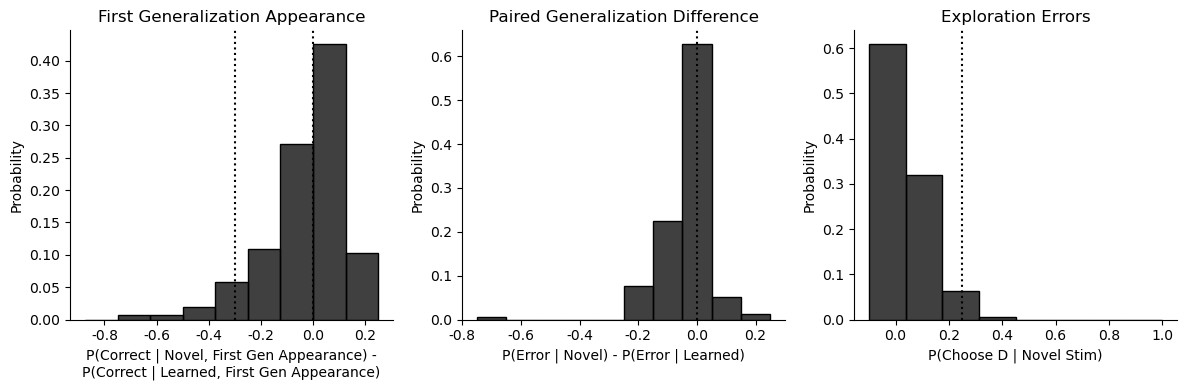

In [3]:
perf_thresh = 0.5 # Performance threshold during the initial context for determining if a subject is included in generalization
n_trials_back = 10 # Number of trials to look back to calculate performance
save_bool = False # Whether to save the figure

# Do it for the initial set of subjects
data = data_EG_initial
performance_mat_mn, _ = calcSubjectsGenAxis(data, attributes=['color', 'shape', 'texture'], n_trials_back=n_trials_back,
                                            generalization_att='texture', perf_thresh=perf_thresh)
generalization_difference = np.mean(performance_mat_mn[:,1,:] - performance_mat_mn[:,0,:],axis=0)
first_response, first_target_bool, first_correct = subjectsCatGenFirstChoice(data,target_ans=3,block=1,perf_thresh=perf_thresh,n_trials_back=n_trials_back)
generalize_D_prop = np.mean(first_target_bool,axis=1)
first_gen_appearance_correct = calcSubjectsNovelExampleGenTaskFirstCorrectGen(data, thresh=perf_thresh,n_trials_back=n_trials_back)
first_gen_appearance_correct_mn = np.mean(first_gen_appearance_correct,axis=0)
first_gen_appearance_correct_mn_diff = first_gen_appearance_correct_mn[1,:] - first_gen_appearance_correct_mn[0,:]
eg_metric_df_initial = pd.DataFrame({
    'P(Error | Novel) - P(Error | Learned)': generalization_difference, 
    'P(Choose D | Novel Stim)': np.mean(first_target_bool,axis=1),
    'P(Correct | Novel, First Gen Appearance) -\nP(Correct | Learned, First Gen Appearance)': first_gen_appearance_correct_mn[1,:] - first_gen_appearance_correct_mn[0,:]
})
plotExampleGenMetrics(eg_metric_df_initial, replication=False,save_bool=False,fig_dir='plots/subjects/',extension='svg',
    fig_name='example_gen_metrics')
plt.show()

# Do it for the replication set of subjects
data = data_EG_replication
performance_mat_mn, _ = calcSubjectsGenAxis(data, attributes=['color', 'shape', 'texture'], n_trials_back=n_trials_back,
                                            generalization_att='texture', perf_thresh=perf_thresh)
generalization_difference = np.mean(performance_mat_mn[:,1,:] - performance_mat_mn[:,0,:],axis=0)
first_response, first_target_bool, first_correct = subjectsCatGenFirstChoice(data,target_ans=3,block=1,perf_thresh=perf_thresh,n_trials_back=n_trials_back)
generalize_D_prop = np.mean(first_target_bool,axis=1)
first_gen_appearance_correct = calcSubjectsNovelExampleGenTaskFirstCorrectGen(data, thresh=perf_thresh,n_trials_back=n_trials_back)
first_gen_appearance_correct_mn = np.mean(first_gen_appearance_correct,axis=0)
first_gen_appearance_correct_mn_diff = first_gen_appearance_correct_mn[1,:] - first_gen_appearance_correct_mn[0,:]
eg_metric_df_replication = pd.DataFrame({
    'P(Error | Novel) - P(Error | Learned)': generalization_difference, 
    'P(Choose D | Novel Stim)': np.mean(first_target_bool,axis=1),
    'P(Correct | Novel, First Gen Appearance) -\nP(Correct | Learned, First Gen Appearance)': first_gen_appearance_correct_mn[1,:] - first_gen_appearance_correct_mn[0,:]
})
plotExampleGenMetrics(eg_metric_df_replication, replication=True,save_bool=False,fig_dir='plots/subjects/',extension='svg',
    fig_name='example_gen_metrics')
plt.show()

## Run the statistics on summary data

In [ ]:
df_stats_initial = calcExampleGenMetricStats(eg_metric_df_initial,first_gen_diff_thresh=-0.3)
from IPython.display import clear_output
clear_output(wait=False)
# print(df_stats_initial.to_latex(index=False))
display(df_stats_initial)

df_stats_replication = calcExampleGenMetricStats(eg_metric_df_replication,first_gen_diff_thresh=-0.3)
from IPython.display import clear_output
clear_output(wait=False)
# print(df_stats_replication.to_latex(index=False))
display(df_stats_replication)

# Context generalization Version 1 (Experiment 2)

In [11]:
conversion = figurePrototypesConversion(experimental_set='humans', context_gen_version=1)

largest_chosen, generalization_initial_error_rates, confusion_matrix, set_key, subj_ids = calcLCInitialErrorConfMat(data_CGv1,
                                            thresh=0.5, trial_window=10,context_gen_version=1,return_subject_ids=True)

confusion_vals, _ = createSetGenBarDfHelper(confusion_matrix, conversion,
                                    confusion_method='all', norm_bool=True)


/Users/wpettine/Dropbox/_Murray/Project/state_creation_RL/Paper/code/repos/instrumentalLatentStateLearning/subjects/subjectsfunctions.py:531: RuntimeWarning: invalid value encountered in true_divide
  confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None, :]
/Users/wpettine/Dropbox/_Murray/Project/state_creation_RL/Paper/code/repos/instrumentalLatentStateLearning/subjects/subjectsfunctions.py:546: RuntimeWarning: Mean of empty slice
  diff_mn = np.nanmean(diff, axis=0)
/Users/wpettine/Dropbox/_Murray/Project/state_creation_RL/Paper/code/repos/instrumentalLatentStateLearning/subjects/subjectsfunctions.py:585: RuntimeWarning: invalid value encountered in true_divide
  descrim_confusion = num / denom


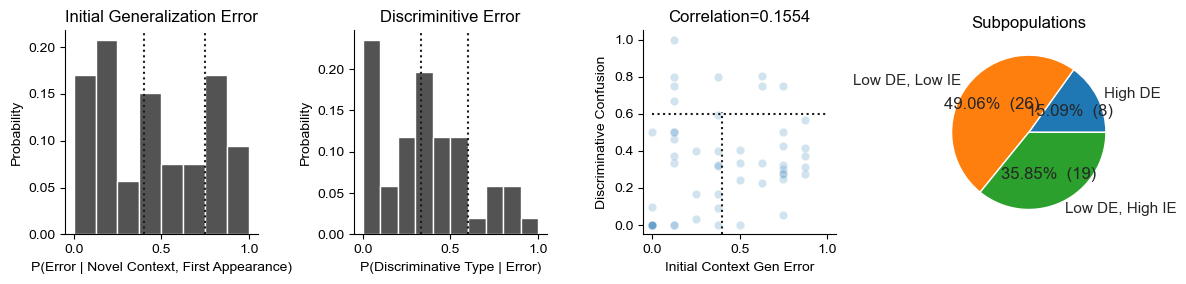

In [12]:
def tidyAx(ax,remove_legend=True,ttl='',xlabel=None,fontsize=12):
    ax = removeSpines(ax)
    ax.set_title(ttl,fontsize=fontsize)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    return ax

save_bool = False
extension = 'svg'
# fig_dir = '/Users/wpettine/Dropbox/_Murray/Code/state_inference_RL/analysis/plots'
fig_dir = 'plots/subjects'

df_summary = pd.DataFrame({
    'Initial Context Gen Error': 1-np.mean(generalization_initial_error_rates,axis=1),
    'Discriminative Confusion': confusion_vals                                   
})

cutoff_discrim=0.6
cutoff_initial_error=0.4

indx_de = df_summary['Discriminative Confusion']>cutoff_discrim
indx_ie = df_summary['Initial Context Gen Error']>cutoff_initial_error
initial_gen_error = 1-np.mean(generalization_initial_error_rates,axis=1)

n_de = sum(indx_de)
n_nde_nie = sum((indx_de<1)*(indx_ie<1))
n_nde_ie = sum((indx_de<1)*(indx_ie))
counts = [n_de,n_nde_nie,n_nde_ie]

fig, ax = plt.subplots(1,4,figsize=(12,3))

sns.set()
ax[2].axvline(0.4,ymax=0.6,color='k',linestyle=':')
ax[2].plot(ax[2].get_xlim(),[.6,.6],color='k',linestyle=':')
ax[0] = sns.histplot(ax=ax[0],data=df_summary,x='Initial Context Gen Error',bins=np.arange(0,1+(1/8),(1/8)),color='k',stat='probability')
ax[1] = sns.histplot(ax=ax[1],data=df_summary,x='Discriminative Confusion',bins=10,color='k',stat='probability')
ax[2] = sns.scatterplot(ax=ax[2],data=df_summary,x='Initial Context Gen Error',y='Discriminative Confusion',alpha=0.2)
ax[3].pie(counts, labels=['High DE','Low DE, Low IE','Low DE, High IE'],autopct=make_autopct(counts))

indx = (np.isnan(df_summary['Initial Context Gen Error'])<1) & (np.isnan(df_summary['Discriminative Confusion'])<1)
r = np.round(np.corrcoef(df_summary.loc[indx,'Initial Context Gen Error'],df_summary.loc[indx,'Discriminative Confusion'])[0,1],4)

ax[0].axvline(.75,color='k',linestyle=':')
ax[0].axvline(cutoff_initial_error,color='k',linestyle=':')
ax[1].axvline(.33,color='k',linestyle=':')
ax[1].axvline(cutoff_discrim,color='k',linestyle=':')

ax[0] = tidyAx(ax[0],ttl='Initial Generalization Error', xlabel='P(Error | Novel Context, First Appearance)')
ax[1] = tidyAx(ax[1],ttl='Discriminitive Error',xlabel='P(Discriminative Type | Error)')
ax[2] = tidyAx(ax[2],ttl=f'Correlation={r}')
ax[3].set_title('Subpopulations')

fig.tight_layout()
if save_bool:
    fig.savefig(os.path.join(fig_dir,f'cgv1_metrics.{extension}'),dpi=300)
plt.show()

## Stats (CGv1)

In [10]:
df_stats_icge = calcContextGenStats(df_summary['Initial Context Gen Error'].to_numpy(),alpha=0.05,label='Initial Context Gen Error',\
                     mu=0.75,groups=['All','HDE','LDE','HIE','LIE','LDE-HIE','LDE-LIE'],indx_de=indx_de,indx_ie=indx_ie)

df_stats_de = calcContextGenStats(df_summary['Discriminative Confusion'].to_numpy(),alpha=0.05,label='Discriminative Error',\
                     mu=0.33,groups=['All','HDE','LDE','HIE','LIE','LDE-HIE','LDE-LIE'],indx_de=indx_de,indx_ie=indx_ie)

df_stats = pd.concat([df_stats_icge,df_stats_de])

from IPython.display import clear_output
clear_output(wait=False)

display(df_stats)

,Mean,STD,T Stat,P-Val,Effect Size,Power,BF,Group,Metric
0,0.417067,0.299042,-11.299066,1.000000e+00,1.394677,1.0,4.850602e-20,All,Initial Context Gen Error
1,0.427632,0.262252,-7.477131,1.000000e+00,1.630615,1.0,3.310271e-09,HDE,Initial Context Gen Error
2,0.410985,0.318142,-8.591209,1.000000e+00,1.291827,1.0,1.304740e-12,LDE,Initial Context Gen Error
3,0.680288,0.145884,-3.412575,9.993660e-01,4.663216,1.0,8.162446e-04,HIE,Initial Context Gen Error
4,0.153846,0.137839,-30.886654,1.000000e+00,1.116128,1.0,5.544138e-35,LIE,Initial Context Gen Error
5,0.725000,0.138444,-0.972446,8.305648e-01,5.236785,1.0,2.174011e-01,LDE-HIE,Initial Context Gen Error
6,0.149306,0.137624,-25.822128,1.000000e+00,1.084877,1.0,1.119227e-24,LDE-LIE,Initial Context Gen Error
0,0.448736,0.282665,4.242401,2.438602e-05,1.587519,1.0,3.312536e+04,All,Discriminative Error
1,0.751699,0.171212,14.981927,1.364529e-17,4.390443,1.0,7.328533e+16,HDE,Discriminative Error
2,0.271620,0.156343,-2.987280,9.980066e-01,1.737336,1.0,2.373812e-03,LDE,Discriminative Error


## Confusion Matrices (CGv1)

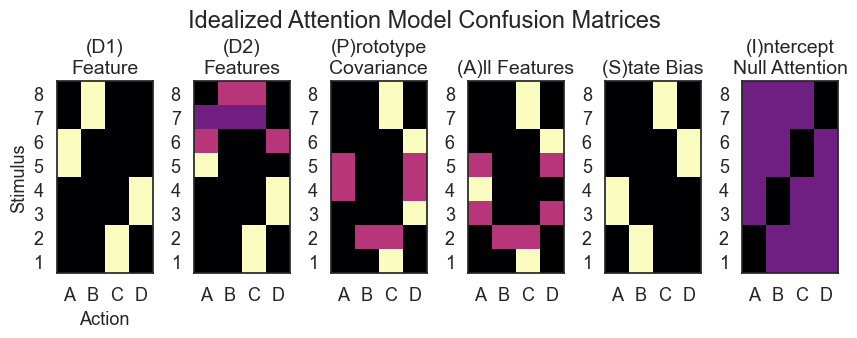

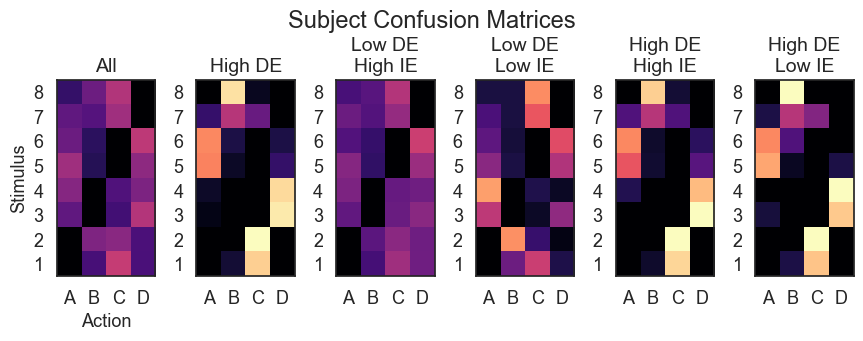

In [5]:
plotContextGenIdealizedConfMats(save_bool=False,fig_dir=None,extension='svg',\
    fig_scale_factor=0.8,fontsize=13,conversion=None,context_gen_version=1)
plt.show()
plotContextGenSubjectConfMats(confusion_matrix,indx_de,indx_ie,context_gen_version=1,conversion=None,save_bool=False,\
    fig_dir='plots/subjects',extension='svg',fontsize=13,fig_scale_factor=0.8)
plt.show()

## Bayesian fit (CGv1)
### Fit the data

In [14]:
subjects = 'de'

if subjects == 'all':
    indx_subjects = np.ones(len(indx_de)).astype(bool)
elif subjects == 'de':
    indx_subjects = indx_de
elif subjects == 'de_ie':
    indx_subjects = indx_de * indx_ie
elif subjects == 'de_lie':
    indx_subjects = indx_de * (indx_ie<1)
elif subjects == 'lde':
    indx_subjects = indx_de<1
elif subjects == 'lde_ie':
    indx_subjects = (indx_de<1) * indx_ie
elif subjects == 'lde_lie':
    indx_subjects = (indx_de<1) * (indx_ie<1)

fit_dict = fitBayesianWithAssessment(confusion_matrix,context_gen_version=1,priors='half_normal',
                              conf_mat_method='winner',experimental_set='humans',cores=None,fit_init='adapt_diag')

print('Saving fit results')
data_dir = 'subjects/data/fit_results/'
data_file_name = 'bayesian_fit_analysis_cgv1'
with open(os.path.join(data_dir, f'{data_file_name}_{subjects}.pickle'), 'wb') as buff:
    pickle.dump(fit_dict,buff)


Fitting Model


KeyError: "['D'] not in index"

### Plot Bayesian results (CGv1)

Loading fit results
plotting posterior predictive
plotting partial correlations
plotting model comparison


0

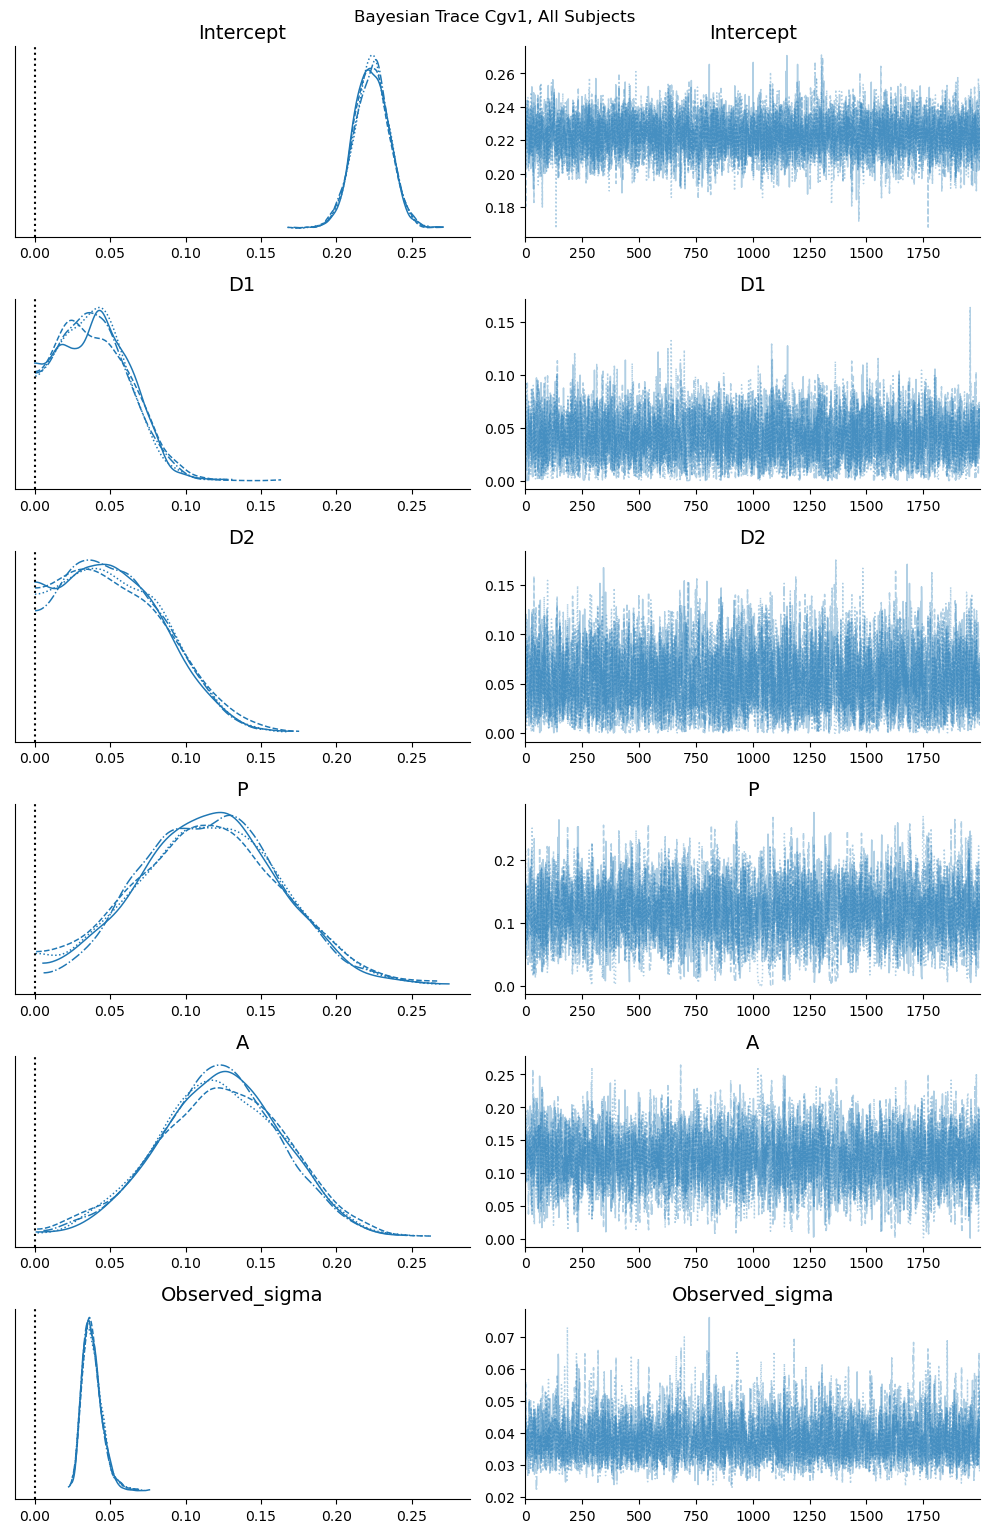

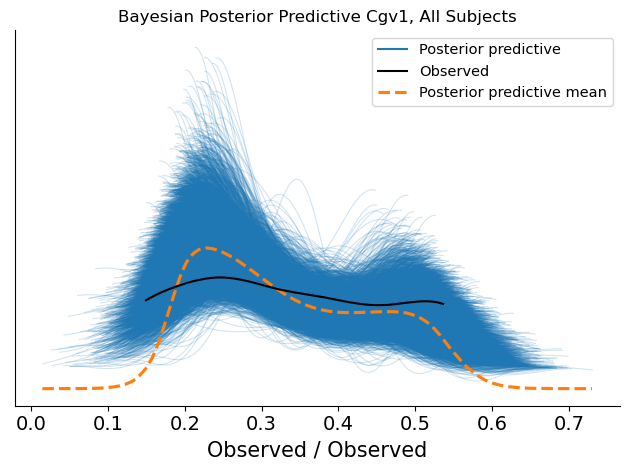

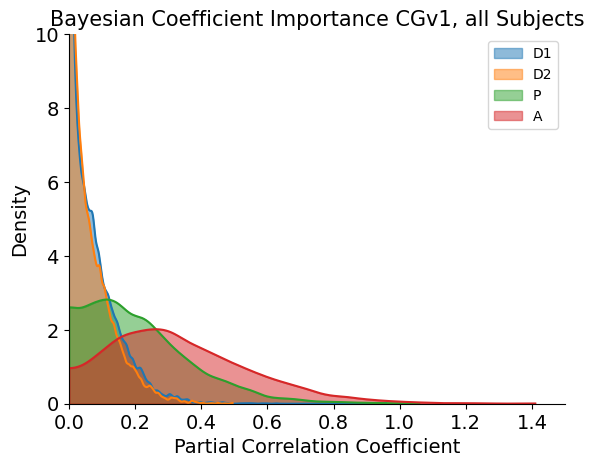

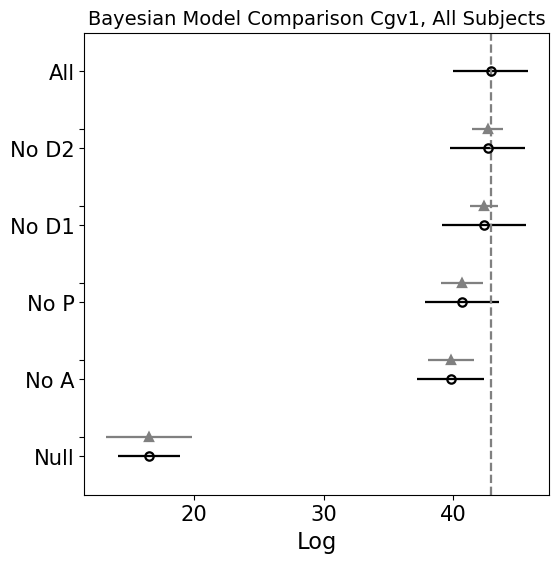

In [6]:
print('Loading fit results')
data_dir = 'subjects/data/fit_results/'
data_file_name = 'bayesian_fit_analysis'
fig_dir = 'plots/subjects'
subjects = 'all'

with open(os.path.join(data_dir, f'{data_file_name}.pickle'), 'rb') as buff:
    fit_dict = pickle.load(buff)

plotBayesianWithAssessment(fit_dict['fitted_dict'], fit_dict['df_compare'], fit_dict['pcorr_samples'],
                                fig_dir=fig_dir, ttl_base=f'CGv1, {subjects} Subjects',
                                extension='svg')

# Context Generalization Version 2 (Experiment 3)

In [3]:
data = data_CGv2_replication # data_CGv2_initial, data_CGv2_replication

conversion = figurePrototypesConversion(experimental_set='humans', context_gen_version=2)

largest_chosen, generalization_initial_error_rates, confusion_matrix, set_key, subj_ids = calcLCInitialErrorConfMat(data,
                                            thresh=0.5, trial_window=10,context_gen_version=2,return_subject_ids=True)

confusion_vals, group_stim_diff_vals = createSetGenBarDfHelper(confusion_matrix, conversion,
                                    confusion_method='all', norm_bool=True)

/Users/wpettine/Dropbox/_Murray/Project/state_creation_RL/Paper/code/repos/instrumentalLatentStateLearning/subjects/subjectsfunctions.py:531: RuntimeWarning: invalid value encountered in true_divide
  confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, None, :]
/Users/wpettine/Dropbox/_Murray/Project/state_creation_RL/Paper/code/repos/instrumentalLatentStateLearning/subjects/subjectsfunctions.py:546: RuntimeWarning: Mean of empty slice
  diff_mn = np.nanmean(diff, axis=0)
/Users/wpettine/Dropbox/_Murray/Project/state_creation_RL/Paper/code/repos/instrumentalLatentStateLearning/subjects/subjectsfunctions.py:585: RuntimeWarning: invalid value encountered in true_divide
  descrim_confusion = num / denom


## Plot the summaries (CGv2)

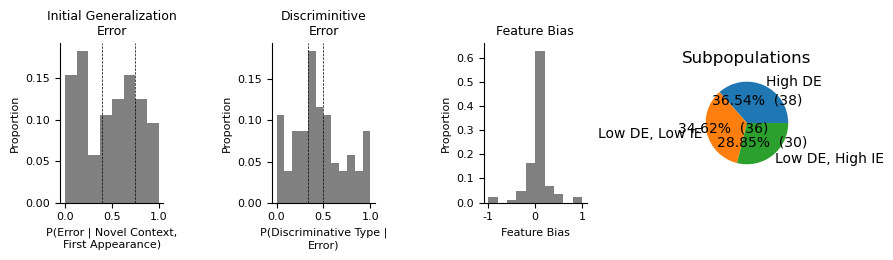

In [4]:
def tidyAx(ax,remove_legend=True,ttl='',xlabel=None,fontsize=12,ylabel='Proportion'):
    ax = removeSpines(ax)
    ax.set_title(ttl,fontsize=fontsize+1)
    if xlabel is not None:
        ax.set_xlabel(xlabel,fontsize=fontsize)
    ax.set_ylabel(ylabel,fontsize=fontsize)
    ax.tick_params(labelsize=fontsize)
    return ax

extension = 'svg'
fig_dir = 'plots/replication'
save_bool = False
fontsize=8
linewidth = 0.5

df_summary = pd.DataFrame({
    'subject_id':subj_ids,
    'Initial Context Gen Error': 1-np.mean(generalization_initial_error_rates,axis=1),
    'Discriminative Confusion': confusion_vals, 
    # 'Total Errors': p_total_error,
    'Feature Bias': group_stim_diff_vals,
    # 'Context Diff Initial Error': p_initial_error_set_1 - p_initial_error_set_2,
    # 'Context Diff Total Error': p_total_error_set_1 - p_total_error_set_2,
})

cutoff_discrim = 0.5
cutoff_initial_error = 0.4

indx_de = df_summary['Discriminative Confusion']>cutoff_discrim
indx_ie = df_summary['Initial Context Gen Error']>cutoff_initial_error

groups = np.array([None]*len(confusion_vals))
groups[indx_de] = 'High DE'
groups[(indx_de<1)*(indx_ie<1)] = 'Low DE, Low IE'
groups[(indx_de<1)*(indx_ie)] = 'Low DE, High IE'
df_summary['Group'] = groups

n_de = sum(indx_de)
n_nde_nie = sum((indx_de<1)*(indx_ie<1))
n_nde_ie = sum((indx_de<1)*(indx_ie))
counts = [n_de,n_nde_nie,n_nde_ie]

fig, ax = plt.subplots(1,4,figsize=np.array([15,4.5])*.6)
color = (0.5,0.5,0.5)
ax[0] = sns.histplot(ax=ax[0],data=df_summary,x='Initial Context Gen Error',bins=np.arange(0,1+(1/8),(1/8)),
    color=color,stat='probability',linewidth=0,alpha=1)
ax[1] = sns.histplot(ax=ax[1],data=df_summary,x='Discriminative Confusion',bins=12,color=color,stat='probability',
    linewidth=0,alpha=1)
ax[2] = sns.histplot(ax=ax[2],data=df_summary,x='Feature Bias',bins=10,color=color,stat='probability',
    linewidth=0,alpha=1)
ax[3].pie(counts, labels=['High DE','Low DE, Low IE','Low DE, High IE'],autopct=make_autopct(counts))

ax[0] = tidyAx(ax[0],ttl='Initial Generalization\nError', xlabel='P(Error | Novel Context,\nFirst Appearance)',fontsize=fontsize)
ax[1] = tidyAx(ax[1],ttl='Discriminitive\nError',xlabel='P(Discriminative Type |\nError)',fontsize=fontsize)
ax[2] = tidyAx(ax[2],ttl='Feature Bias',fontsize=fontsize,xlabel='Feature Bias')
ax[3].set_title('Subpopulations')

ax[0].axvline(.75,color='k',linestyle='--',linewidth=linewidth)
ax[0].axvline(cutoff_initial_error,color='k',linestyle='--',linewidth=linewidth)
ax[1].axvline(cutoff_discrim,color='k',linestyle='--',linewidth=linewidth)
ax[1].axvline(.33,color='k',linestyle='--',linewidth=linewidth)

fig.tight_layout()
if save_bool:
    fig.savefig(os.path.join(fig_dir,f'cgv2_metrics.{extension}'),dpi=300)

plt.show()

## Confusion matrices (CGv2)

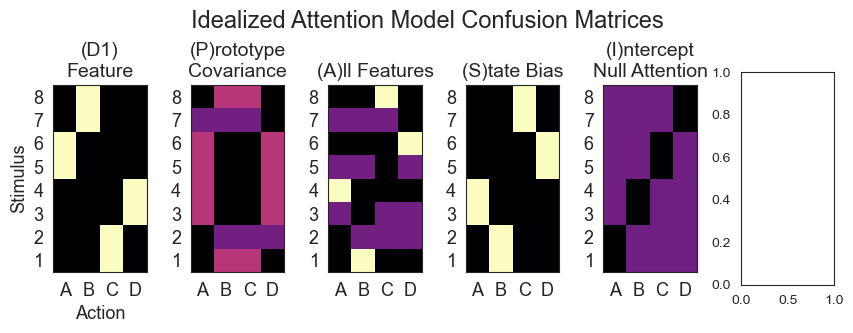

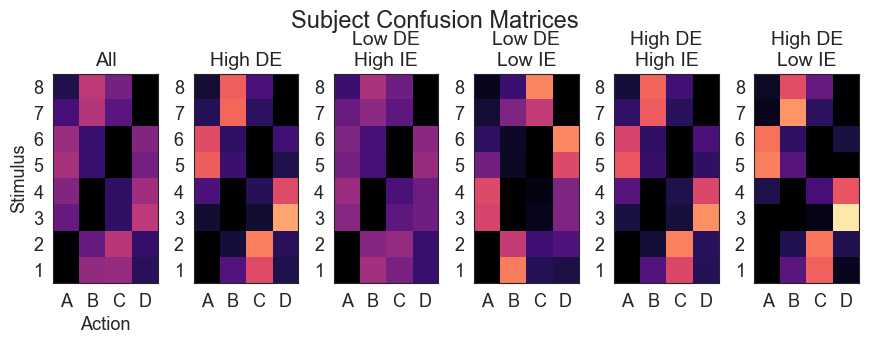

In [8]:
plotContextGenIdealizedConfMats(save_bool=False,fig_dir=None,extension='svg',\
    fig_scale_factor=0.8,fontsize=13,conversion=None,context_gen_version=2)
plt.show()
plotContextGenSubjectConfMats(confusion_matrix,indx_de,indx_ie,context_gen_version=2,conversion=None,save_bool=False,\
    fig_dir='plots/subjects',extension='svg',fontsize=13,fig_scale_factor=0.8)
plt.show()

## Bayesian fits (CGv2)
### Fit the stuff

In [5]:
subjects = 'all'

if subjects == 'all':
    indx_subjects = np.ones(len(indx_de)).astype(bool)
elif subjects == 'de':
    indx_subjects = indx_de
elif subjects == 'de_ie':
    indx_subjects = indx_de * indx_ie
elif subjects == 'de_lie':
    indx_subjects = indx_de * (indx_ie<1)
elif subjects == 'lde':
    indx_subjects = indx_de<1
elif subjects == 'lde_ie':
    indx_subjects = (indx_de<1) * indx_ie
elif subjects == 'lde_lie':
    indx_subjects = (indx_de<1) * (indx_ie<1)

# Variables to fit to the behavioral data
# fit_vars = ['D','P','A'] # Discriminative, prototype, all-features
fitvars = ['P','S'] # Prototype, state_bias

fit_dict = fitBayesianWithAssessment(confusion_matrix,context_gen_version=1,priors='half_normal',fitvars=fitvars,
                              conf_mat_method='winner',experimental_set='humans',cores=None,fit_init='adapt_diag')

print('Saving fit results')
data_dir = 'subjects/data/fit_results/'
data_file_name = 'bayesian_fit_analysis_cgv2'
with open(os.path.join(data_dir, f'{data_file_name}_{"".join(fitvars)}_{subjects}.pickle'), 'wb') as buff:
    pickle.dump(fit_dict,buff)


Fitting Model


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Observed_sigma, S, P, Intercept]


/Users/wpettine/opt/anaconda3/envs/py39mc/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/wpettine/opt/anaconda3/envs/py39mc/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/wpettine/opt/anaconda3/envs/py39mc/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/wpettine/opt/anaconda3/envs/py39mc/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 26 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Calculating Posterior predictive
Partial correlations
Model comparison


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Observed_sigma, S, Intercept]


/Users/wpettine/opt/anaconda3/envs/py39mc/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/wpettine/opt/anaconda3/envs/py39mc/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/wpettine/opt/anaconda3/envs/py39mc/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/wpettine/opt/anaconda3/envs/py39mc/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 25 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning

/Users/wpettine/opt/anaconda3/envs/py39mc/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/wpettine/opt/anaconda3/envs/py39mc/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/wpettine/opt/anaconda3/envs/py39mc/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/wpettine/opt/anaconda3/envs/py39mc/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 24 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. 

/Users/wpettine/opt/anaconda3/envs/py39mc/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/wpettine/opt/anaconda3/envs/py39mc/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/wpettine/opt/anaconda3/envs/py39mc/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/wpettine/opt/anaconda3/envs/py39mc/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 21 seconds.


Saving fit results


In [ ]:
val =True
if not val:
    print('here')

### Plot Bayesian coefficients (CGv2)

plotting posterior predictive
plotting partial correlations
plotting model comparison


0

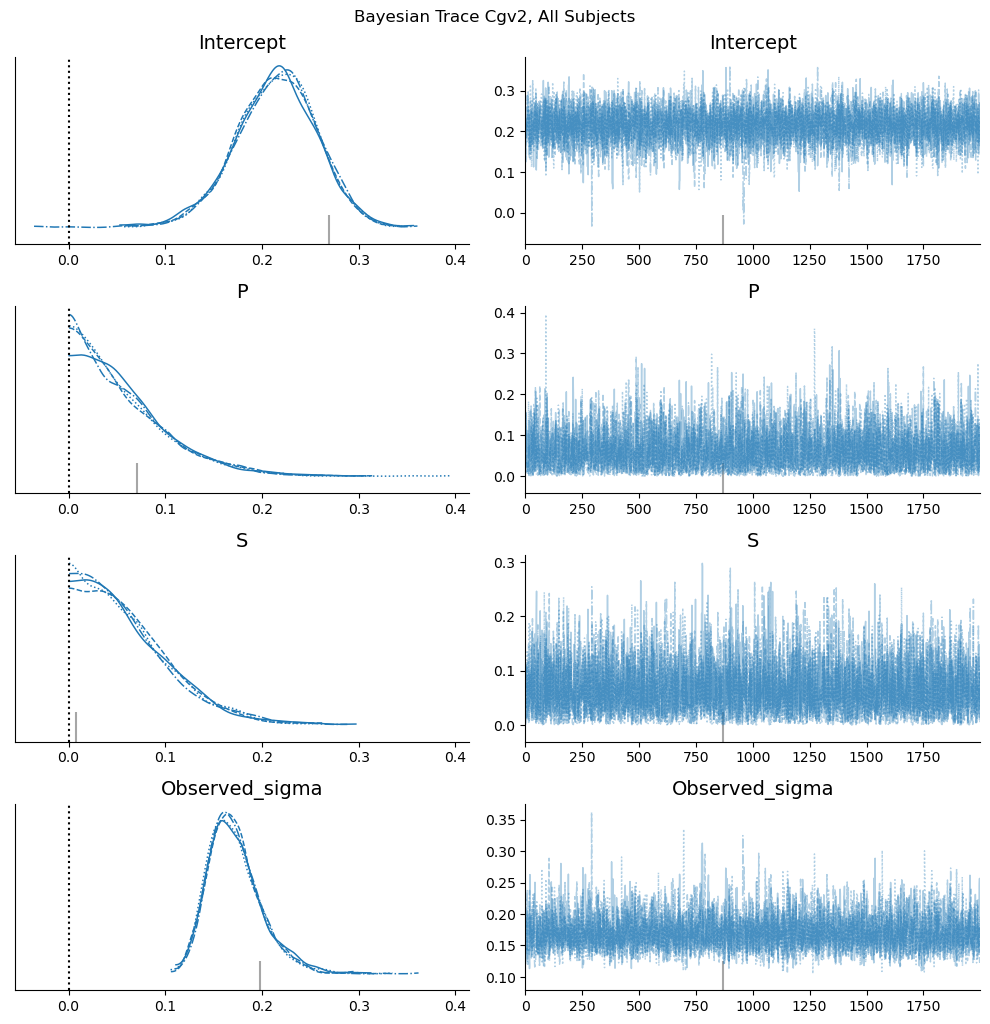

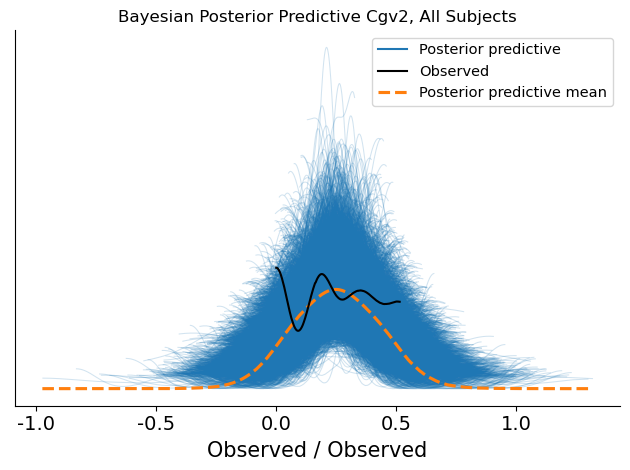

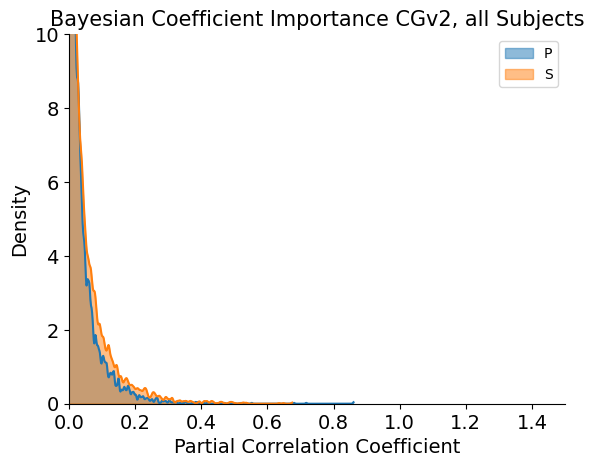

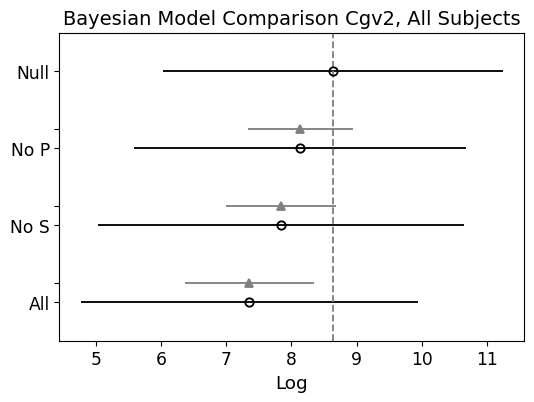

In [7]:
# print('Loading fit results')
# data_dir = 'subjects/data/fit_results/'
# data_file_name = 'bayesian_fit_analysis_cgv2_PS_all'
fig_dir = 'plots/subjects'
# subjects = 'all'

# with open(os.path.join(data_dir, f'{data_file_name}.pickle'), 'rb') as buff:
#     fit_dict = pickle.load(buff)

plotBayesianWithAssessment(fit_dict['fitted_dict'], fit_dict['df_compare'], fit_dict['pcorr_samples'],
                                fig_dir=fig_dir, ttl_base=f'CGv2, {subjects} Subjects',
                                extension='svg')